In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

jaisheesh_input_docs_path = kagglehub.dataset_download('jaisheesh/input-docs')

print('Data source import complete.')


# Main dewarping script file

In [ ]:
%%bash
cat > /kaggle/working/dewarp_script.py <<'PY'

# <-- paste your full script here (the whole file contents you showed me) -->


import os
import glob
import argparse
import numpy as np
import cv2
from scipy import interpolate
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torchvision.models import resnet34

# -------------------------
# Synthetic warp generation
# -------------------------
def generate_flat_grid(w, h):
    u = np.arange(w, dtype=np.float32)
    v = np.arange(h, dtype=np.float32)
    U, V = np.meshgrid(u, v, indexing='xy')
    return U, V

def cylindrical_warp(X, Y, radius=800.0, axis='x', center=None):
    H, W = X.shape
    if center is None:
        cx = (W - 1) / 2.0
        cy = (H - 1) / 2.0
    else:
        cx, cy = center
    Xc = X - cx
    Yc = Y - cy
    if axis == 'x':
        theta = Xc / radius
        Xs = radius * np.sin(theta) + cx
        Z = radius * (1.0 - np.cos(theta))
        Ys = Yc + cy
        return Xs, Ys, Z
    elif axis == 'y':
        theta = Yc / radius
        Ys = radius * np.sin(theta) + cy
        Z = radius * (1.0 - np.cos(theta))
        Xs = Xc + cx
        return Xs, Ys, Z
    else:
        raise ValueError("axis must be 'x' or 'y'")

def spherical_warp(X, Y, radius=1200.0, center=None):
    H, W = X.shape
    if center is None:
        cx = (W - 1) / 2.0
        cy = (H - 1) / 2.0
    else:
        cx, cy = center
    Xc = X - cx
    Yc = Y - cy
    R = np.sqrt(Xc**2 + Yc**2)
    theta = R / radius
    small = R == 0
    Xs = np.zeros_like(Xc)
    Ys = np.zeros_like(Yc)
    Xs[~small] = (radius * np.sin(theta[~small]) * (Xc[~small] / R[~small]))
    Ys[~small] = (radius * np.sin(theta[~small]) * (Yc[~small] / R[~small]))
    Xs = Xs + cx
    Ys = Ys + cy
    Z = radius * (1.0 - np.cos(theta))
    return Xs, Ys, Z

def perspective_project(X3, Y3, Z3, focal=800.0, cam_z=1000.0, image_center=None):
    H, W = X3.shape
    if image_center is None:
        cx = (W - 1) / 2.0
        cy = (H - 1) / 2.0
    else:
        cx, cy = image_center
    Xc = X3 - cx
    Yc = Y3 - cy
    Zc = Z3 + cam_z
    eps = 1e-8
    Zc_safe = np.maximum(Zc, eps)
    U = (focal * (Xc / Zc_safe)) + cx
    V = (focal * (Yc / Zc_safe)) + cy
    return U, V

def analytic_inverse_cylindrical(out_w, out_h, radius, focal, cam_z, center, src_w, src_h, axis='x'):
    cx, cy = center
    Ug, Vg = np.meshgrid(np.arange(out_w, dtype=np.float32),
                         np.arange(out_h, dtype=np.float32),
                         indexing='xy')
    valid = np.ones((out_h, out_w), dtype=np.uint8)
    if axis == 'x':
        us = np.arange(out_w, dtype=np.float32)
        thetas = np.zeros_like(us, dtype=np.float32)
        def g(theta, u):
            num = radius * np.sin(theta)
            den = (radius * (1.0 - np.cos(theta)) + cam_z)
            return focal * (num / den) + cx - u
        theta_grid = np.linspace(-np.pi/2, np.pi/2, 400, dtype=np.float32)
        for j, u in enumerate(us):
            # try coarse grid then refine by bisection if sign change
            vals = g(theta_grid, u)
            idx = np.argmin(np.abs(vals))
            thetas[j] = theta_grid[idx]
            # small local bisection around selected theta
            a = max(theta_grid[max(0, idx-1)], -np.pi/2)
            b = min(theta_grid[min(len(theta_grid)-1, idx+1)], np.pi/2)
            ga = g(a, u); gb = g(b, u)
            if ga * gb <= 0:
                ta, tb = a, b
                for _ in range(24):
                    tm = 0.5 * (ta + tb)
                    gm = g(tm, u)
                    if ga * gm <= 0:
                        tb = tm; gb = gm
                    else:
                        ta = tm; ga = gm
                thetas[j] = 0.5 * (ta + tb)
        Xc_src = radius * thetas
        X_src = cx + Xc_src
        Zc_cols = radius * (1.0 - np.cos(thetas)) + cam_z
        src_x = np.tile(X_src[None, :], (out_h, 1))
        src_y = cy + ((Vg - cy) * (Zc_cols[None, :] / focal))
        valid &= (src_x >= 0) & (src_x <= (src_w - 1)) & (src_y >= 0) & (src_y <= (src_h - 1))
        return src_x.astype(np.float32), src_y.astype(np.float32), valid.astype(np.uint8)
    else:
        vs = np.arange(out_h, dtype=np.float32)
        thetas = np.zeros_like(vs, dtype=np.float32)
        def g_row(theta, v):
            num = radius * np.sin(theta)
            den = (radius * (1.0 - np.cos(theta)) + cam_z)
            return focal * (num / den) + cy - v
        theta_grid = np.linspace(-np.pi/2, np.pi/2, 400, dtype=np.float32)
        for i, v in enumerate(vs):
            vals = g_row(theta_grid, v)
            idx = np.argmin(np.abs(vals))
            thetas[i] = theta_grid[idx]
            a = max(theta_grid[max(0, idx-1)], -np.pi/2)
            b = min(theta_grid[min(len(theta_grid)-1, idx+1)], np.pi/2)
            ga = g_row(a, v); gb = g_row(b, v)
            if ga * gb <= 0:
                ta, tb = a, b
                for _ in range(24):
                    tm = 0.5 * (ta + tb)
                    gm = g_row(tm, v)
                    if ga * gm <= 0:
                        tb = tm; gb = gm
                    else:
                        ta = tm; ga = gm
                thetas[i] = 0.5 * (ta + tb)
        Yc_src = radius * thetas
        Y_src = cy + Yc_src
        Zc_rows = radius * (1.0 - np.cos(thetas)) + cam_z
        src_y = np.tile(Y_src[:, None], (1, out_w))
        src_x = cx + ((Ug - cx) * (Zc_rows[:, None] / focal))
        valid &= (src_x >= 0) & (src_x <= (src_w - 1)) & (src_y >= 0) & (src_y <= (src_h - 1))
        return src_x.astype(np.float32), src_y.astype(np.float32), valid.astype(np.uint8)

def rasterize_inverse_mapping(U, V, X_src, Y_src, out_shape, method='linear'):
    H_out, W_out = out_shape
    pts = np.stack([U.ravel(), V.ravel()], axis=-1)
    vals_x = X_src.ravel()
    vals_y = Y_src.ravel()
    u_coords = np.arange(W_out, dtype=np.float32)
    v_coords = np.arange(H_out, dtype=np.float32)
    Ug, Vg = np.meshgrid(u_coords, v_coords, indexing='xy')
    src_x = interpolate.griddata(pts, vals_x, (Ug, Vg), method=method)
    src_y = interpolate.griddata(pts, vals_y, (Ug, Vg), method=method)
    valid = np.isfinite(src_x) & np.isfinite(src_y)
    if not np.all(valid):
        src_x_nn = interpolate.griddata(pts, vals_x, (Ug, Vg), method='nearest')
        src_y_nn = interpolate.griddata(pts, vals_y, (Ug, Vg), method='nearest')
        src_x[~valid] = src_x_nn[~valid]
        src_y[~valid] = src_y_nn[~valid]
        valid = np.isfinite(src_x) & np.isfinite(src_y)
    return src_x.astype(np.float32), src_y.astype(np.float32), valid.astype(np.uint8)

def generate_warp_for_image(img, warp_type='cylindrical', axis='x', radius=None,
                            focal=None, cam_z=None, out_shape=None,
                            interp=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE,
                            radius_range=(0.8, 2.5), focal_range=(0.8, 1.6), camz_range=(1.0, 2.0)):
    """
    Generate warped image, flow_map and mask.

    flow_map[y,x] = [src_x - x, src_y - y]
    Returned mask is uint8 with values {0,255}.
    """
    H, W = img.shape[:2]
    if out_shape is None:
        out_shape = (H, W)

    # sample geometry parameters if not provided
    if radius is None:
        radius = max(W, H) * np.random.uniform(radius_range[0], radius_range[1])
    if focal is None:
        focal = max(W, H) * np.random.uniform(focal_range[0], focal_range[1])
    if cam_z is None:
        cam_z = max(W, H) * np.random.uniform(camz_range[0], camz_range[1])

    X, Y = generate_flat_grid(W, H)
    center = ((W - 1) / 2.0, (H - 1) / 2.0)

    if warp_type == 'cylindrical':
        X3, Y3, Z3 = cylindrical_warp(X, Y, radius=radius, axis=axis, center=center)
        U, V = perspective_project(X3, Y3, Z3, focal=focal, cam_z=cam_z, image_center=center)
        src_x_map, src_y_map, valid = analytic_inverse_cylindrical(
            out_shape[1], out_shape[0], radius, focal, cam_z, center, W, H, axis=axis)
    elif warp_type == 'spherical':
        X3, Y3, Z3 = spherical_warp(X, Y, radius=radius, center=center)
        U, V = perspective_project(X3, Y3, Z3, focal=focal, cam_z=cam_z, image_center=center)
        src_x_map, src_y_map, valid = rasterize_inverse_mapping(U, V, X, Y, out_shape, method='linear')
    else:
        raise ValueError("warp_type must be 'cylindrical' or 'spherical'")

    H_out, W_out = out_shape

    # original float maps for mask/outside detection
    src_x_map_orig = src_x_map.astype(np.float32)
    src_y_map_orig = src_y_map.astype(np.float32)

    # clipped maps used for remap
    src_x_map_clipped = np.clip(src_x_map_orig, 0.0, float(W - 1))
    src_y_map_clipped = np.clip(src_y_map_orig, 0.0, float(H - 1))

    # compute flow: source_coords - target_grid_coords
    ugrid, vgrid = generate_flat_grid(W_out, H_out)
    ugrid = ugrid.astype(np.float32)
    vgrid = vgrid.astype(np.float32)

    flow_x = (src_x_map_clipped - ugrid).astype(np.float32)
    flow_y = (src_y_map_clipped - vgrid).astype(np.float32)
    flow_map = np.stack([flow_x, flow_y], axis=2)

    # prepare source image (uint8)
    img_src = img.copy() if img.dtype == np.uint8 else (img * 255.0).astype(np.uint8)

    # remap expects float32
    map_x = src_x_map_clipped.astype(np.float32)
    map_y = src_y_map_clipped.astype(np.float32)

    warped = cv2.remap(img_src, map_x, map_y, interpolation=interp, borderMode=borderMode)

    # mask: start from 'valid' (returned by inverse mapping) AND mark outside using the ORIGINAL maps
    mask = (valid == 1).astype(np.uint8)
    outside = (src_x_map_orig < 0.0) | (src_x_map_orig > (W - 1)) | (src_y_map_orig < 0.0) | (src_y_map_orig > (H - 1))
    mask[outside] = 0
    mask = (mask * 255).astype(np.uint8)

    return warped, flow_map.astype(np.float32), mask



def process_folder(input_folder, output_folder, out_size=None, warp_types=('cylindrical','spherical'), max_images=None):
    os.makedirs(output_folder, exist_ok=True)
    files = []
    for ext in ('png', 'jpg', 'jpeg', 'tif'):
        files += glob.glob(os.path.join(input_folder, f'*.{ext}'))
    files = sorted(files)
    if len(files) == 0:
        raise FileNotFoundError(f"No images found in {input_folder}")
    if max_images is not None:
        files = files[:max_images]
    for p in files:
        fname = os.path.splitext(os.path.basename(p))[0]
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Skipping unreadable: {p}")
            continue
        warp_type = np.random.choice(list(warp_types))
        axis = np.random.choice(['x','y'])
        H,W = img.shape[:2]
        out_shape = out_size if out_size is not None else (H,W)
        warped_img, flow_map, mask = generate_warp_for_image(img, warp_type=warp_type, axis=axis, out_shape=out_shape)
        out_base = os.path.join(output_folder, fname)
        warped_path = out_base + '_warped.png'
        flow_path = out_base + '_flow_map.npy'
        mask_path = out_base + '_mask.png'
        cv2.imwrite(warped_path, warped_img)
        np.save(flow_path, flow_map)
        cv2.imwrite(mask_path, mask)
        print(f"Saved: {os.path.basename(warped_path)}, {os.path.basename(flow_path)}, {os.path.basename(mask_path)}")

# -------------------------
# Network (ResNet34 U-Net)
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch:int, out_ch:int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch:int, out_ch:int):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x, skip):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        dy = skip.size(2) - x.size(2)
        dx = skip.size(3) - x.size(3)
        if dy !=0 or dx!=0:
            x = F.pad(x, [dx//2, dx-dx//2, dy//2, dy-dy//2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=3, pretrained=True):
        super().__init__()
        resnet = resnet34(pretrained=pretrained)
        self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu) # 64,H/2
        self.pool = resnet.maxpool
        self.enc1 = resnet.layer1 #64,H/4
        self.enc2 = resnet.layer2 #128,H/8
        self.enc3 = resnet.layer3 #256,H/16
        self.enc4 = resnet.layer4 #512,H/32
        self.up4 = UpBlock(512+256, 256)
        self.up3 = UpBlock(256+128, 128)
        self.up2 = UpBlock(128+64, 64)
        self.up1 = UpBlock(64+64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0 = self.enc0(x)
        p = self.pool(e0)
        e1 = self.enc1(p)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        d4 = self.up4(e4, e3)
        d3 = self.up3(d4, e2)
        d2 = self.up2(d3, e1)
        d1 = self.up1(d2, e0)
        out_up = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.final_conv(out_up)
        flow = out[:,0:2,:,:].contiguous()
        mask = torch.sigmoid(out[:,2:3,:,:].contiguous())
        return flow, mask

# -------------------------
# Dataset
# -------------------------
class DewarpDataset(Dataset):
    TARGET_W = 1024
    TARGET_H = 960
    def __init__(self, items):
        super().__init__()
        if not isinstance(items, list):
            raise ValueError("items must be a list of (img, flow, mask) tuples")
        self.items = items
    def __len__(self):
        return len(self.items)
    @staticmethod
    def _read_image(path):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise RuntimeError(f"Could not read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    @staticmethod
    def _read_flow(path):
        if path.lower().endswith('.npy'):
            arr = np.load(path)
        else:
            arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            if arr is None:
                raise RuntimeError(f"Could not read flow: {path}")
            arr = arr.astype(np.float32)
            if arr.ndim ==3 and arr.shape[2]>=2:
                arr = arr[..., :2]
        if arr.ndim==2:
            arr = np.stack([arr, np.zeros_like(arr)], axis=-1)
        if arr.shape[-1]!=2:
            raise RuntimeError(f"Flow must have 2 channels, got {arr.shape}")
        return arr.astype(np.float32)
    @staticmethod
    def _read_mask(path):
        if path.lower().endswith('.npy'):
            m = np.load(path)
        else:
            m = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            if m is None:
                raise RuntimeError(f"Could not read mask: {path}")
            if m.ndim==3:
                m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
        m = (m>0).astype(np.uint8)
        return m
    @staticmethod
    def _resize_and_pad_img(img, target_w, target_h):
        h0,w0 = img.shape[:2]
        if w0==0 or h0==0:
            raise RuntimeError("Invalid image with zero dimension")
        scale = min(target_w/float(w0), target_h/float(h0))
        new_w = max(1, int(round(w0*scale)))
        new_h = max(1, int(round(h0*scale)))
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        pad_left = (target_w - new_w)//2
        pad_right = target_w - new_w - pad_left
        pad_top = (target_h - new_h)//2
        pad_bottom = target_h - new_h - pad_top
        if img.ndim==3:
            padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
        else:
            padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)
        return padded, scale, (pad_top, pad_left)
    @staticmethod
    def _resize_and_pad_flow(flow, target_w, target_h):
        h0,w0 = flow.shape[:2]
        if w0==0 or h0==0:
            raise RuntimeError("Invalid flow with zero dimension")
        scale = min(target_w/float(w0), target_h/float(h0))
        new_w = max(1, int(round(w0*scale)))
        new_h = max(1, int(round(h0*scale)))
        ch0 = cv2.resize(flow[...,0], (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        ch1 = cv2.resize(flow[...,1], (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        ch0 = ch0 * scale
        ch1 = ch1 * scale
        resized = np.stack([ch0,ch1], axis=-1)
        pad_left = (target_w - new_w)//2
        pad_top = (target_h - new_h)//2
        padded = np.zeros((target_h, target_w, 2), dtype=resized.dtype)
        padded[pad_top:pad_top+new_h, pad_left:pad_left+new_w, :] = resized
        return padded, scale, (pad_top, pad_left)
    @staticmethod
    def _resize_and_pad_mask(mask, target_w, target_h):
        h0,w0 = mask.shape[:2]
        if w0==0 or h0==0:
            raise RuntimeError("Invalid mask with zero dimension")
        scale = min(target_w/float(w0), target_h/float(h0))
        new_w = max(1, int(round(w0*scale)))
        new_h = max(1, int(round(h0*scale)))
        resized = cv2.resize(mask.astype(np.uint8), (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        pad_left = (target_w - new_w)//2
        pad_top = (target_h - new_h)//2
        padded = np.zeros((target_h, target_w), dtype=np.uint8)
        padded[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = (resized>0).astype(np.uint8)
        return padded, scale, (pad_top, pad_left)
    def __getitem__(self, idx):
        img_path, flow_path, mask_path = self.items[idx]
        img = self._read_image(img_path)
        flow = self._read_flow(flow_path)
        mask = self._read_mask(mask_path)
        img_padded, scale_img, (pt_img, pl_img) = self._resize_and_pad_img(img, self.TARGET_W, self.TARGET_H)
        flow_padded, scale_flow, (pt_flow, pl_flow) = self._resize_and_pad_flow(flow, self.TARGET_W, self.TARGET_H)
        mask_padded, scale_mask, (pt_mask, pl_mask) = self._resize_and_pad_mask(mask, self.TARGET_W, self.TARGET_H)
        # ensure alignment (defensive)
        if not (abs(scale_img-scale_flow)<1e-6 and abs(scale_img-scale_mask)<1e-6):
            flow_padded, _, _ = self._resize_and_pad_flow(flow, self.TARGET_W, self.TARGET_H)
            mask_padded, _, _ = self._resize_and_pad_mask(mask, self.TARGET_W, self.TARGET_H)
        img_tensor = torch.from_numpy(img_padded.astype(np.float32)/255.0).permute(2,0,1).contiguous()
        flow_tensor = torch.from_numpy(flow_padded.astype(np.float32)).permute(2,0,1).contiguous()
        mask_tensor = torch.from_numpy(mask_padded.astype(np.float32))[None,...].contiguous()
        return img_tensor, flow_tensor, mask_tensor

# -------------------------
# Loss
# -------------------------
class DewarpLoss(nn.Module):
    def __init__(self, mask_weight=0.5):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.bce = nn.BCELoss()
        self.mask_weight = float(mask_weight)
    def forward(self, pred_flow, pred_mask, gt_flow, gt_mask):
        if gt_mask.dim() == pred_mask.dim()-1:
            gt_mask = gt_mask.unsqueeze(1)
        gt_mask = gt_mask.type_as(pred_mask)
        loss_l1 = self.l1(pred_flow, gt_flow)
        loss_bce = self.bce(pred_mask, gt_mask)
        return loss_l1 + self.mask_weight * loss_bce

# -------------------------
# Utilities: autodiscover triplets
# -------------------------
def autodiscover_triplets(root):
    exts = ('png','jpg','jpeg')
    warped_files = []
    for e in exts:
        warped_files += glob.glob(os.path.join(root, f'*_warped.{e}'))
    warped_files = sorted(warped_files)
    items = []
    for w in warped_files:
        base = os.path.splitext(os.path.basename(w))[0].replace('_warped','')
        flow = os.path.join(os.path.dirname(w), base + '_flow_map.npy')
        mask = os.path.join(os.path.dirname(w), base + '_mask.png')
        if os.path.exists(flow) and os.path.exists(mask):
            items.append((w, flow, mask))
    return items

# -------------------------
# Training loop
# -------------------------
def train_main(data_root, out_dir, epochs=50, batch=4, lr=5e-4, num_workers=2, device=None):
    device = torch.device(device or ('cuda' if torch.cuda.is_available() else 'cpu'))
    items = autodiscover_triplets(data_root)
    if not items:
        raise RuntimeError("No triplets found. Run data generation first.")
    dataset = DewarpDataset(items)
    n = len(dataset)
    n_train = int(0.9*n)
    train_set = Subset(dataset, list(range(0,n_train)))
    val_set = Subset(dataset, list(range(n_train,n)))
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch, shuffle=False, num_workers=num_workers, pin_memory=True)
    model = ResNetUNet(n_classes=3, pretrained=True).to(device)
    criterion = DewarpLoss(mask_weight=0.5)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    os.makedirs(out_dir, exist_ok=True)
    best_val = float('inf')
    best_path = os.path.join(out_dir, 'best_model.pth')
    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0; cnt = 0
        for imgs, flows, masks in train_loader:
            imgs = imgs.to(device); flows = flows.to(device); masks = masks.to(device)
            optimizer.zero_grad()
            pred_flow, pred_mask = model(imgs)
            loss = criterion(pred_flow, pred_mask, flows, masks)
            loss.backward(); optimizer.step()
            bs = imgs.size(0)
            running += loss.item() * bs; cnt += bs
        train_loss = running / max(1, cnt)
        # validate
        model.eval()
        vrunning = 0.0; vcnt = 0
        with torch.no_grad():
            for imgs, flows, masks in val_loader:
                imgs = imgs.to(device); flows = flows.to(device); masks = masks.to(device)
                pred_flow, pred_mask = model(imgs)
                loss = criterion(pred_flow, pred_mask, flows, masks)
                bs = imgs.size(0)
                vrunning += loss.item() * bs; vcnt += bs
        val_loss = vrunning / max(1, vcnt)
        print(f"Epoch {epoch:03d} Train {train_loss:.6f} Val {val_loss:.6f}")
        torch.save(model.state_dict(), os.path.join(out_dir, 'last_model.pth'))
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), best_path)
            print("Saved best model:", best_path)

# -------------------------
# Dewarp single image using model
# -------------------------

def dewarp_image(
    ckpt, input_image, out_path,
    mask_threshold=0.3,  # lower for smoother blending
    bg='white',
    device=None,
    scale_factor=0.02,    # flow strength scaling
):
    import torch, cv2, os, numpy as np
    from dewarp_script import ResNetUNet, DewarpDataset

    # --- Device setup ---
    device = torch.device(device or ('cuda' if torch.cuda.is_available() else 'cpu'))

    # --- Load model ---
    if not os.path.exists(ckpt):
        raise FileNotFoundError(ckpt)
    model = ResNetUNet(n_classes=3, pretrained=False).to(device)
    state = torch.load(ckpt, map_location=device)

    # handle state dict wrappers
    if isinstance(state, dict) and 'state_dict' in state:
        state = state['state_dict']
    if isinstance(state, dict):
        state = {k.replace('module.', ''): v for k, v in state.items()}
    model.load_state_dict(state)
    model.eval()

    # --- Load image ---
    orig_bgr = cv2.imread(input_image, cv2.IMREAD_COLOR)
    if orig_bgr is None:
        raise FileNotFoundError(input_image)
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    h0, w0 = orig_rgb.shape[:2]

    # --- Resize and pad (same as training) ---
    img_padded, scale, (pad_top, pad_left) = DewarpDataset._resize_and_pad_img(
        orig_rgb, DewarpDataset.TARGET_W, DewarpDataset.TARGET_H
    )

    input_tensor = (
        torch.from_numpy(img_padded.astype(np.float32) / 255.0)
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(device)
    )

    # --- Model prediction ---
    with torch.no_grad():
        pred_flow, pred_mask = model(input_tensor)

    flow_np = pred_flow.squeeze(0).cpu().numpy().transpose(1, 2, 0).astype(np.float32)
    mask_np = pred_mask.squeeze(0).squeeze(0).cpu().numpy().astype(np.float32)

    Hm, Wm = flow_np.shape[:2]
    ugrid, vgrid = np.meshgrid(
        np.arange(Wm, dtype=np.float32),
        np.arange(Hm, dtype=np.float32),
        indexing='xy'
    )

    # --- Smooth flow to remove jitter ---
    flow_np[..., 0] = cv2.GaussianBlur(flow_np[..., 0], (5, 5), 3)
    flow_np[..., 1] = cv2.GaussianBlur(flow_np[..., 1], (5, 5), 3)
    flow_np = cv2.GaussianBlur(flow_np, (5,5), 0)
    # --- Apply corrected inverse mapping ---
    map_x = (ugrid - scale_factor * flow_np[..., 0])
    map_y = (vgrid - scale_factor * flow_np[..., 1])

    import numpy as np, cv2
    flow = flow_np.copy()              # H x W x 2 float32
    mag = np.sqrt(flow[...,0]**2 + flow[...,1]**2)
    ang = np.arctan2(flow[...,1], flow[...,0])
    h = (ang + np.pi) / (2*np.pi) * 180          # angle->hue
    s = np.clip(mag / (np.percentile(mag,98)+1e-6), 0, 1)*255
    v = np.clip(mag / (np.percentile(mag,98)+1e-6), 0, 1)*255
    hsv = np.stack([h.astype(np.uint8), s.astype(np.uint8), v.astype(np.uint8)], axis=-1)
    flow_vis = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.imwrite('/kaggle/working/flow_vis.png', flow_vis)

    # --- Clamp to valid coordinates ---
    src_h, src_w = img_padded.shape[:2]
    map_x = np.clip(map_x, 0, src_w - 1)
    map_y = np.clip(map_y, 0, src_h - 1)

    # --- Remap image ---
    src_img = (
        img_padded
        if img_padded.dtype == np.uint8
        else (np.clip(img_padded, 0.0, 1.0) * 255.0).astype(np.uint8)
    )
    remapped = cv2.remap(
        src_img,
        map_x.astype(np.float32),
        map_y.astype(np.float32),
        interpolation=cv2.INTER_LANCZOS4,
        borderMode=cv2.BORDER_REPLICATE,  # smoother edges
    )
    # Right after remap
    remapped = cv2.detailEnhance(remapped, sigma_s=10, sigma_r=0.15)
    print("src_img", src_img.dtype, "map_x", map_x.dtype, "map_y", map_y.dtype, "remapped", remapped.dtype)
    img = remapped  # result from step 1
    up = cv2.resize(img, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_CUBIC)
    up = cv2.fastNlMeansDenoisingColored(up, None, 6, 6, 7, 21)
    kernel = np.array([[-1,-1,-1],[-1,15,-1],[-1,-1,-1]], dtype=np.float32)/10.0
    sharp_up = cv2.filter2D(up, -1, kernel)
# aggressive CLAHE
    lab = cv2.cvtColor(sharp_up, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    l = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(l)
    sharp_up = cv2.cvtColor(cv2.merge([l,a,b]), cv2.COLOR_LAB2BGR)
    final = cv2.resize(sharp_up, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)
    cv2.imwrite('/kaggle/working/dewarped_sr_like.png', final)

    # --- Process mask ---
    mask_bin = (mask_np >= float(mask_threshold)).astype(np.uint8)
    mask_bin = cv2.dilate(mask_bin, np.ones((5, 5), np.uint8), iterations=1)

    # --- Blend background ---
    if remapped.ndim == 2:
        remapped = cv2.cvtColor(remapped, cv2.COLOR_GRAY2RGB)

    bg_color = (255,255,255) if bg=='white' else (0,0,0)
    bg_arr = np.array(bg_color, dtype=remapped.dtype)
    mask_3c = mask_bin[:, :, None].astype(bool)
    out_padded_rgb = np.where(mask_3c, remapped, bg_arr)


    # --- Crop and resize back to original ---
    new_w = int(round(w0 * scale))
    new_h = int(round(h0 * scale))
    top, left = pad_top, pad_left
    cropped = out_padded_rgb[top:top + new_h, left:left + new_w]
    final_rgb = cv2.resize(cropped, (w0, h0), interpolation=cv2.INTER_LINEAR)

    # --- Save result ---
    final_bgr = cv2.cvtColor(final_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(out_path, final_bgr)
    print(f"✅ Saved dewarped: {out_path}")


# -------------------------
# Smoke test
# -------------------------
def smoke_test(dataset_root):
    triplets = autodiscover_triplets(dataset_root)
    if not triplets:
        raise RuntimeError("No triplets found for smoke test")
    ds = DewarpDataset(triplets[:4])
    dl = DataLoader(ds, batch_size=2, shuffle=False)
    model = ResNetUNet(n_classes=3, pretrained=True)
    model.eval()
    imgs, flows, masks = next(iter(dl))
    with torch.no_grad():
        f, m = model(imgs)
    print("Shapes: imgs", imgs.shape, "pred_flow", f.shape, "pred_mask", m.shape, "gt_flow", flows.shape, "gt_mask", masks.shape)

# -------------------------
# CLI
# -------------------------
def main(argv=None):
    """
    Robust main:
    - If argv is provided (programmatic call), parse it.
    - If running in a real shell (notebook not detected) and no argv -> use sys.argv.
    - If running in interactive environment (IPython/Colab) and no argv -> print help and return.
    """
    import sys

    parser = argparse.ArgumentParser(description="All-in-one Kaggle script for synthetic data + train + infer")
    sub = parser.add_subparsers(dest='cmd', required=True)
    p_gen = sub.add_parser('gen', help='Generate synthetic data')
    p_gen.add_argument('--input', '-i', required=True)
    p_gen.add_argument('--output', '-o', required=True)
    p_gen.add_argument('--num_images', type=int, default=None)
    p_gen.add_argument('--out_w', type=int, default=None)
    p_gen.add_argument('--out_h', type=int, default=None)
    p_train = sub.add_parser('train', help='Train model')
    p_train.add_argument('--data_root', '-d', required=True)
    p_train.add_argument('--out', '-o', default='./checkpoints')
    p_train.add_argument('--epochs', type=int, default=50)
    p_train.add_argument('--batch', type=int, default=4)
    p_train.add_argument('--lr', type=float, default=1e-4)
    p_train.add_argument('--num_workers', type=int, default=2)
    p_smoke = sub.add_parser('smoke', help='Run smoke test')
    p_smoke.add_argument('--data', '-d', required=True)
    p_dewarp = sub.add_parser('dewarp', help='Apply model to single image')
    p_dewarp.add_argument('--ckpt', required=True)
    p_dewarp.add_argument('--image', required=True)
    p_dewarp.add_argument('--out', required=True)
    p_dewarp.add_argument('--mask-th', type=float, default=0.5)

    # decide argv source
    if argv is None:
        # running normally: inspect environment
        # If in IPython/Colab, prefer to not parse sys.argv (they contain kernel flags)
        try:
            get_ip = get_ipython  # raises NameError outside IPython
            # We're in IPython / Colab: do not attempt to parse injected argv
            # Print help so user knows how to call the script
            parser.print_help()
            return
        except Exception:
            # not in IPython: use sys.argv[1:] (normal CLI)
            argv = sys.argv[1:]

    # If caller passed argv explicitly (programmatic), use it directly.
    # Validate argv so accidental kernel tokens are ignored:
    if isinstance(argv, (list, tuple)):
        # drop obvious kernel artifacts (e.g. '-f' and paths ending in .json)
        argv = [a for a in argv if not (isinstance(a, str) and (a == '-f' or a.endswith('.json')))]
    else:
        argv = []

    if not argv:
        parser.print_help()
        return

    args = parser.parse_args(argv)

    if args.cmd == 'gen':
        out_size = None
        if args.out_w is not None and args.out_h is not None:
            out_size = (args.out_h, args.out_w)
        process_folder(args.input, args.output, out_size, max_images=args.num_images)
    elif args.cmd == 'train':
        train_main(args.data_root, args.out, epochs=args.epochs, batch=args.batch, lr=args.lr, num_workers=args.num_workers)
    elif args.cmd == 'smoke':
        smoke_test(args.data)
    elif args.cmd == 'dewarp':
        dewarp_image(args.ckpt, args.image, args.out, mask_threshold=args.mask_th)
    else:
        parser.print_help()



if __name__ == '__main__':
    main()

PY

In [ ]:
!ls -la /kaggle/working/dewarp_script.py


-rw-r--r-- 1 root root 32375 Nov  9 16:46 /kaggle/working/dewarp_script.py


**Generate syntetic data**

In [ ]:
!python /kaggle/working/dewarp_script.py gen \
  --input /kaggle/input/input-docs/input_docs \
  --output /kaggle/working/synthetic-data \
  --num_images 100


Saved: PMC3576793_00004_warped.png, PMC3576793_00004_flow_map.npy, PMC3576793_00004_mask.png
Saved: PMC3654277_00006_warped.png, PMC3654277_00006_flow_map.npy, PMC3654277_00006_mask.png
Saved: PMC3777717_00006_warped.png, PMC3777717_00006_flow_map.npy, PMC3777717_00006_mask.png
Saved: PMC3863500_00003_warped.png, PMC3863500_00003_flow_map.npy, PMC3863500_00003_mask.png
Saved: PMC3976938_00002_warped.png, PMC3976938_00002_flow_map.npy, PMC3976938_00002_mask.png
Saved: PMC4027932_00001_warped.png, PMC4027932_00001_flow_map.npy, PMC4027932_00001_mask.png
Saved: PMC4527132_00004_warped.png, PMC4527132_00004_flow_map.npy, PMC4527132_00004_mask.png
Saved: PMC5344221_00010_warped.png, PMC5344221_00010_flow_map.npy, PMC5344221_00010_mask.png
Saved: PMC5432924_00001_warped.png, PMC5432924_00001_flow_map.npy, PMC5432924_00001_mask.png
Saved: PMC5447509_00002_warped.png, PMC5447509_00002_flow_map.npy, PMC5447509_00002_mask.png
Saved: PMC5491943_00004_warped.png, PMC5491943_00004_flow_map.npy, PMC

**Train the model**

In [ ]:
!python /kaggle/working/dewarp_script.py train \
  --data_root /kaggle/working/synthetic-data \
  --out /kaggle/working/checkpoints \
  --epochs 300 \
  --batch 4 \
  --lr 5e-4 \
  --num_workers 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|███████████████████████████████████████| 83.3M/83.3M [00:00<00:00, 190MB/s]
Epoch 001 Train 29.951502 Val 37.070343
Saved best model: /kaggle/working/checkpoints/best_model.pth
Epoch 002 Train 29.651294 Val 37.040501
Saved best model: /kag

In [ ]:
!ls -la /kaggle/working/checkpoints


total 191696
drwxr-xr-x 2 root root     4096 Nov  9 16:48 .
drwxr-xr-x 5 root root     4096 Nov  9 16:48 ..
-rw-r--r-- 1 root root 98141064 Nov  9 17:01 best_model.pth
-rw-r--r-- 1 root root 98141064 Nov  9 17:02 last_model.pth


**Handling errors**

In [ ]:
# --- Patch for IndexError in dewarp_image ---
import re

with open('/kaggle/working/dewarp_script.py', 'r') as f:
    code = f.read()

# find and replace the old block (the one assigning background color)
new_block = """
    # ensure remapped is 3-channel RGB
    if remapped.ndim == 2:
        remapped = cv2.cvtColor(remapped, cv2.COLOR_GRAY2RGB)

    # boolean mask: True = keep, False = replace with background
    mask_bool = (mask_np >= float(mask_threshold))

    # fix: handle possible size mismatch
    if mask_bool.shape != remapped.shape[:2]:
        mask_bool = cv2.resize(mask_bool.astype(np.uint8), (remapped.shape[1], remapped.shape[0]),
                               interpolation=cv2.INTER_NEAREST).astype(bool)

    out_padded_rgb = remapped.copy()
    bg_color = (255, 255, 255) if bg == 'white' else (0, 0, 0)
    bg_arr = np.array(bg_color, dtype=out_padded_rgb.dtype)
    out_padded_rgb[~mask_bool] = bg_arr
"""

# replace the line that caused error
code = re.sub(r'out_padded_rgb\[mask_3c==0\][^\n]+', new_block, code)

with open('/kaggle/working/dewarp_script.py', 'w') as f:
    f.write(code)

print("✅ dewarp_image patched successfully")


✅ dewarp_image patched successfully


In [ ]:
!python /kaggle/working/dewarp_script.py dewarp \
  --ckpt /kaggle/working/checkpoints/best_model.pth \
  --image /kaggle/working/synthetic-data/PMC3576793_00004_warped.png \
  --out /kaggle/working/dewarped_fixed.png \
  --mask-th 0.5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
src_img uint8 map_x float32 map_y float32 remapped uint8
✅ Saved dewarped: /kaggle/working/dewarped_fixed.png


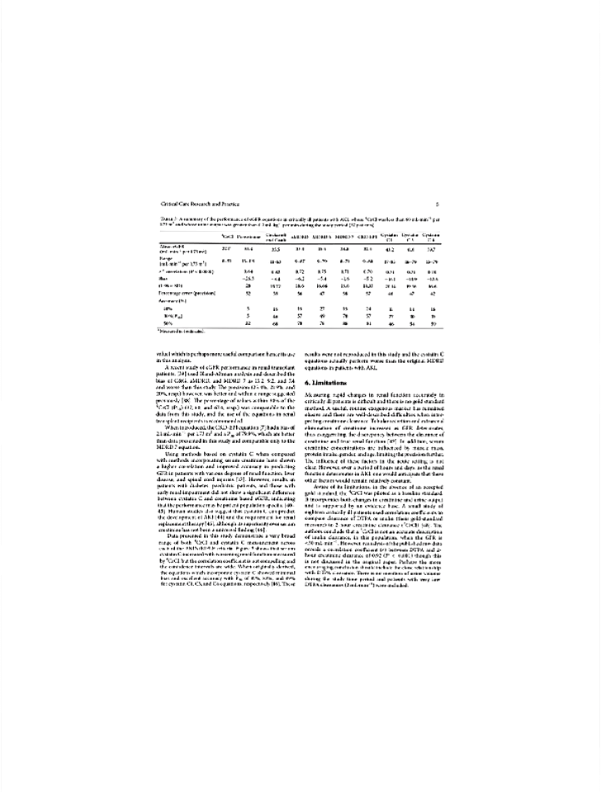

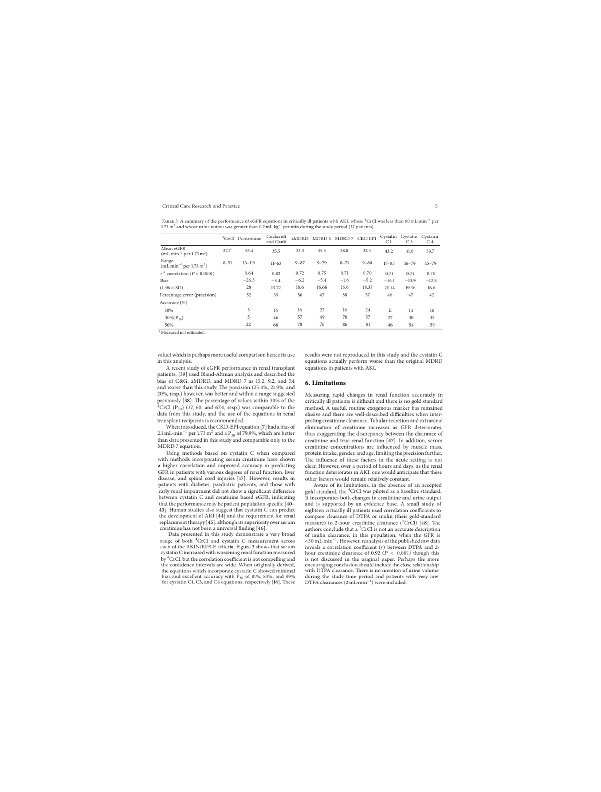

In [ ]:
from IPython.display import Image
display(Image('/kaggle/working/dewarped_fixed.png'))
display(Image('/kaggle/working/synthetic-data/PMC3576793_00004_warped.png'))


In [ ]:
# import cv2, numpy as np, os
# from IPython.display import Image, display

# IN = '/kaggle/working/dewarped_fixed.png'
# OUT = '/kaggle/working/dewarped_rectified.png'
# DEBUG = '/kaggle/working/dewarp_debug.png'

# assert os.path.exists(IN), f"Input not found: {IN}"
# img = cv2.imread(IN)
# h0, w0 = img.shape[:2]

# # --- 1) preprocess to get a solid page mask ---
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # optional blur to reduce small text/noise
# blur = cv2.GaussianBlur(gray, (5,5), 0)

# # Try adaptive threshold (works with uneven lighting) then invert
# _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# th = 255 - th

# # th = 255 - th  # text/ink => white on black background

# # morphological close to join text into page blob; kernel size tuned to page resolution
# k = max(50, int(round(min(w0,h0) / 200)))  # e.g. ~5..10
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k,k))
# closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)

# # small opening to remove tiny specks
# opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)

# # Save debug mask
# cv2.imwrite('/kaggle/working/dewarp_mask.png', opened)

# # --- 2) find contours and choose the largest by area ---
# contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# if not contours:
#     raise RuntimeError("No contours found. Try lower the adaptiveThreshold parameters or use Otsu.")

# # sort contours by area
# contours = sorted(contours, key=cv2.contourArea, reverse=True)
# page_cnt = contours[0]
# area = cv2.contourArea(page_cnt)
# print("Largest contour area:", area, "image area:", w0*h0)

# # --- 3) approximate to 4 points robustly ---
# # use convex hull first (handles concave noise)
# hull = cv2.convexHull(page_cnt)

# # approximate polygon from hull
# peri = cv2.arcLength(hull, True)
# eps = 0.02 * peri
# poly = cv2.approxPolyDP(hull, eps, True)

# # if we didn't get 4 points, force-fit 4 by taking the four extreme points
# if len(poly) != 4:
#     pts = hull.reshape(-1,2)
#     # get extreme points: left-most, right-most, top-most, bottom-most
#     left = pts[np.argmin(pts[:,0])]
#     right = pts[np.argmax(pts[:,0])]
#     top = pts[np.argmin(pts[:,1])]
#     bottom = pts[np.argmax(pts[:,1])]
#     quad = np.vstack([top, right, bottom, left]).astype(np.float32)
#     print("poly len !=4, using extreme points:", quad.shape)
# else:
#     quad = poly.reshape(4,2).astype(np.float32)
#     print("quad from approxPolyDP:", quad.shape)

# # order points to TL,TR,BR,BL
# def order_pts(pts):
#     s = pts.sum(axis=1)
#     diff = np.diff(pts, axis=1).reshape(-1)
#     tl = pts[np.argmin(s)]
#     br = pts[np.argmax(s)]
#     tr = pts[np.argmin(diff)]
#     bl = pts[np.argmax(diff)]
#     return np.array([tl, tr, br, bl], dtype=np.float32)

# src = order_pts(quad)

# # compute destination rectangle sizes
# widthA = np.linalg.norm(src[2] - src[3])
# widthB = np.linalg.norm(src[1] - src[0])
# maxW = int(max(widthA, widthB))

# heightA = np.linalg.norm(src[1] - src[2])
# heightB = np.linalg.norm(src[0] - src[3])
# maxH = int(max(heightA, heightB))

# # pad a bit to avoid cropping tiny edges
# pad = 10
# dst = np.array([[pad, pad],
#                 [maxW-1+pad, pad],
#                 [maxW-1+pad, maxH-1+pad],
#                 [pad, maxH-1+pad]], dtype=np.float32)

# # transform and warp
# M = cv2.getPerspectiveTransform(src, dst)
# warped = cv2.warpPerspective(img, M, (maxW + 2*pad, maxH + 2*pad),
#                              flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

# # save results
# cv2.imwrite(OUT, warped)

# # draw debug overlay on original image
# dbg = img.copy()
# cv2.drawContours(dbg, [page_cnt], -1, (0,255,0), 3)            # original largest contour
# for p in src.reshape(4,2):
#     cv2.circle(dbg, tuple(p.astype(int)), 8, (0,0,255), -1)   # corners used
# cv2.imwrite(DEBUG, dbg)

# print("Wrote rectified ->", OUT)
# print("Wrote debug overlay ->", DEBUG)
# print("Wrote mask ->", '/kaggle/working/dewarp_mask.png')

# # display all three for quick visual check
# # display(Image(DEBUG))
# # display(Image('/kaggle/working/dewarp_mask.png'))
# # display(Image(OUT))


In [ ]:
# from IPython.display import display, Image
# display(Image('/kaggle/working/dewarped_fixed.png'))        # before rectification
# # display(Image('/kaggle/working/dewarp_mask.png'))         # mask used to find page
# # display(Image('/kaggle/working/dewarp_debug.png'))        # overlay of contour on orig
# display(Image('/kaggle/working/dewarped_rectified.png'))  # final rectified


**Dewarping warped images for later evaluation**

In [ ]:
# CELL 1: Batch dewarp — generate model outputs (fixed images)
import os, glob, traceback
from tqdm import tqdm

# Paths — edit if needed
CKPT = "/kaggle/working/checkpoints/best_model.pth"   # your trained checkpoint
WARPED_ROOT = "/kaggle/working/synthetic-data"        # folder that contains *_warped.png (or subfolders)
OUT_DIR = "/kaggle/working/predictions"               # where to save <base>_fixed.png
MASK_TH = 0.5

os.makedirs(OUT_DIR, exist_ok=True)

# import your script (assumes dewarp_script.py is in working dir)
import importlib, dewarp_script
importlib.reload(dewarp_script)

# safe wrapper to call dewarp_image for single file
def run_dewarp_single(ckpt, warped_path, out_path, mask_th=0.5):
    try:
        # dewarp_image handles loading model and writing output
        dewarp_script.dewarp_image(ckpt, warped_path, out_path, mask_threshold=mask_th)
        return True, None
    except Exception as e:
        return False, str(e)

# collect warped images (supporting both flat folder and one-level subfolders)
warped_files = sorted(glob.glob(os.path.join(WARPED_ROOT, "*_warped.png")) +
                      glob.glob(os.path.join(WARPED_ROOT, "**", "*_warped.png"), recursive=True))
print("Found warped files:", len(warped_files))

failures = []
for p in tqdm(warped_files):
    base = os.path.splitext(os.path.basename(p))[0].replace("_warped", "")
    out_path = os.path.join(OUT_DIR, base + "_fixed.png")
    ok, err = run_dewarp_single(CKPT, p, out_path, mask_th=MASK_TH)
    if not ok:
        failures.append((p, err))
        print("Failed:", p, err)

print("Done. Outputs saved to:", OUT_DIR)
if failures:
    print("Failures:", len(failures))
    for f,e in failures[:10]:
        print(" -", f, e)


Found warped files: 36


  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


src_img uint8 map_x float32 map_y float32 remapped uint8


  3%|▎         | 1/36 [00:09<05:31,  9.48s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3576793_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


  6%|▌         | 2/36 [00:18<05:11,  9.16s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3576793_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


  8%|▊         | 3/36 [00:27<04:59,  9.08s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3654277_00006_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 11%|█         | 4/36 [00:36<04:50,  9.08s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3654277_00006_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 14%|█▍        | 5/36 [00:45<04:39,  9.03s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3777717_00006_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 17%|█▋        | 6/36 [00:54<04:30,  9.01s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3777717_00006_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 19%|█▉        | 7/36 [01:03<04:20,  8.98s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3863500_00003_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 22%|██▏       | 8/36 [01:12<04:11,  9.00s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3863500_00003_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 25%|██▌       | 9/36 [01:21<04:02,  8.98s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3976938_00002_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 28%|██▊       | 10/36 [01:30<03:53,  8.96s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC3976938_00002_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 31%|███       | 11/36 [01:39<03:44,  8.96s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC4027932_00001_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 33%|███▎      | 12/36 [01:48<03:34,  8.95s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC4027932_00001_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 36%|███▌      | 13/36 [01:57<03:27,  9.00s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC4527132_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 39%|███▉      | 14/36 [02:06<03:17,  8.99s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC4527132_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 42%|████▏     | 15/36 [02:15<03:08,  8.98s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5344221_00010_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 44%|████▍     | 16/36 [02:24<02:59,  8.97s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5344221_00010_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 47%|████▋     | 17/36 [02:33<02:50,  8.97s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5432924_00001_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 50%|█████     | 18/36 [02:42<02:41,  8.97s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5432924_00001_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 53%|█████▎    | 19/36 [02:50<02:32,  8.96s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5447509_00002_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 56%|█████▌    | 20/36 [02:59<02:23,  8.96s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5447509_00002_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 58%|█████▊    | 21/36 [03:08<02:14,  8.95s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5491943_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 61%|██████    | 22/36 [03:17<02:05,  8.99s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5491943_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 64%|██████▍   | 23/36 [03:26<01:56,  8.98s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5514520_00012_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 67%|██████▋   | 24/36 [03:35<01:47,  8.97s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5514520_00012_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 69%|██████▉   | 25/36 [03:44<01:38,  8.98s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5590435_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 72%|███████▏  | 26/36 [03:53<01:29,  8.98s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5590435_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 75%|███████▌  | 27/36 [04:02<01:20,  8.96s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5618295_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 78%|███████▊  | 28/36 [04:11<01:11,  8.96s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5618295_00004_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 81%|████████  | 29/36 [04:20<01:02,  8.96s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5624106_00000_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 83%|████████▎ | 30/36 [04:29<00:53,  8.97s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5624106_00000_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 86%|████████▌ | 31/36 [04:38<00:45,  9.01s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5678782_00005_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 89%|████████▉ | 32/36 [04:47<00:35,  9.00s/it]

✅ Saved dewarped: /kaggle/working/predictions/PMC5678782_00005_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 92%|█████████▏| 33/36 [04:56<00:27,  9.01s/it]

✅ Saved dewarped: /kaggle/working/predictions/new_0_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 94%|█████████▍| 34/36 [05:05<00:18,  9.02s/it]

✅ Saved dewarped: /kaggle/working/predictions/new_0_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


 97%|█████████▋| 35/36 [05:14<00:09,  9.03s/it]

✅ Saved dewarped: /kaggle/working/predictions/new_1_fixed.png
src_img uint8 map_x float32 map_y float32 remapped uint8


100%|██████████| 36/36 [05:23<00:00,  9.00s/it]

✅ Saved dewarped: /kaggle/working/predictions/new_1_fixed.png
Done. Outputs saved to: /kaggle/working/predictions


**Rectification & Enhancement**

In [ ]:
# CELL 2: Rectify + Enhance functions, then batch process all *_fixed.png
import cv2, numpy as np, os, glob
from tqdm import tqdm

# --- functions ---
def enhance_only(input_path: str, output_path: str,
                 clahe_clip: float = 3.0, clahe_grid=(8,8), sharpen_strength=5):
    """Apply CLAHE and mild sharpening, save result (uint8)."""
    if not os.path.exists(input_path):
        raise FileNotFoundError(input_path)
    img = cv2.imread(input_path)
    if img is None:
        raise RuntimeError("Could not read " + input_path)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_grid)
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2,a,b))
    enhanced = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    kernel = np.array([[0, -1, 0],[-1, sharpen_strength, -1],[0, -1, 0]], dtype=np.float32)
    kernel = kernel / (sharpen_strength - 4) if sharpen_strength != 4 else kernel
    sharpened = cv2.filter2D(enhanced, -1, kernel)
    cv2.imwrite(output_path, np.clip(sharpened, 0, 255).astype(np.uint8))

def rectify_and_enhance(
    input_path: str, output_path: str, debug_dir: str = None,
    clahe_clip: float = 3.0, clahe_grid: tuple = (8,8), sharpen_strength: int = 5, pad: int = 10
):
    """
    Detect page region -> perspective rectify -> enhance -> save output.
    If debug_dir provided, saves mask.png, rectified.png, overlay.png there.
    """
    if not os.path.exists(input_path):
        raise FileNotFoundError(input_path)
    if debug_dir:
        os.makedirs(debug_dir, exist_ok=True)

    img = cv2.imread(input_path)
    if img is None:
        raise RuntimeError("Failed to load: " + input_path)
    h0, w0 = img.shape[:2]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    th = 255 - th

    k = max(50, int(round(min(w0, h0) / 200)))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)

    if debug_dir:
        cv2.imwrite(os.path.join(debug_dir, "mask.png"), opened)

    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise RuntimeError("No contours found for: " + input_path)
    page_cnt = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(page_cnt)
    peri = cv2.arcLength(hull, True)
    eps = 0.02 * peri
    poly = cv2.approxPolyDP(hull, eps, True)

    if len(poly) != 4:
        pts = hull.reshape(-1, 2)
        left = pts[np.argmin(pts[:,0])]
        right = pts[np.argmax(pts[:,0])]
        top = pts[np.argmin(pts[:,1])]
        bottom = pts[np.argmax(pts[:,1])]
        quad = np.vstack([top, right, bottom, left]).astype(np.float32)
    else:
        quad = poly.reshape(4,2).astype(np.float32)

    def order_pts(pts):
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1).reshape(-1)
        tl = pts[np.argmin(s)]
        br = pts[np.argmax(s)]
        tr = pts[np.argmin(diff)]
        bl = pts[np.argmax(diff)]
        return np.array([tl, tr, br, bl], dtype=np.float32)
    src = order_pts(quad)

    widthA = np.linalg.norm(src[2] - src[3])
    widthB = np.linalg.norm(src[1] - src[0])
    heightA = np.linalg.norm(src[1] - src[2])
    heightB = np.linalg.norm(src[0] - src[3])
    maxW = int(max(widthA, widthB))
    maxH = int(max(heightA, heightB))

    dst = np.array([[pad,pad],[maxW-1+pad,pad],[maxW-1+pad,maxH-1+pad],[pad,maxH-1+pad]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    rectified = cv2.warpPerspective(img, M, (maxW + 2*pad, maxH + 2*pad),
                                    flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    if debug_dir:
        cv2.imwrite(os.path.join(debug_dir,"rectified.png"), rectified)

    # enhancement (CLAHE + sharpening)
    lab = cv2.cvtColor(rectified, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_grid)
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2,a,b))
    enhanced = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    kernel = np.array([[0, -1, 0],[-1, sharpen_strength, -1],[0, -1, 0]], dtype=np.float32)
    kernel = kernel / (sharpen_strength - 4) if sharpen_strength != 4 else kernel
    enhanced = cv2.filter2D(enhanced, -1, kernel)
    cv2.imwrite(output_path, np.clip(enhanced, 0, 255).astype(np.uint8))

    if debug_dir:
        dbg = img.copy()
        cv2.drawContours(dbg, [page_cnt], -1, (0,255,0), 3)
        for p in src.reshape(4,2):
            cv2.circle(dbg, tuple(p.astype(int)), 8, (0,0,255), -1)
        cv2.imwrite(os.path.join(debug_dir, "overlay.png"), dbg)
    return output_path

# --- batch processing ---
FIXED_DIR = "/kaggle/working/predictions"   # same as OUT_DIR from CELL 1
OUT_DIR_ENH = "/kaggle/working/predictions/enhanced"
os.makedirs(OUT_DIR_ENH, exist_ok=True)

fixed_files = sorted(glob.glob(os.path.join(FIXED_DIR, "*_fixed.png")))
print("Found fixed model outputs:", len(fixed_files))

for f in tqdm(fixed_files):
    base = os.path.splitext(os.path.basename(f))[0].replace("_fixed","")
    # 1) enhance fixed only
    out_fixed_enh = os.path.join(OUT_DIR_ENH, base + "_fixed_enhanced.png")
    try:
        enhance_only(f, out_fixed_enh, clahe_clip=3.0, clahe_grid=(8,8), sharpen_strength=5)
    except Exception as e:
        print("enhance_only failed for", f, e)
    # 2) rectify + enhance
    out_rectified_enh = os.path.join(OUT_DIR_ENH, base + "_rectified_enhanced.png")
    debug_dir = os.path.join(OUT_DIR_ENH, base + "_debug")
    try:
        rectify_and_enhance(f, out_rectified_enh, debug_dir=debug_dir,
                            clahe_clip=3.0, clahe_grid=(8,8), sharpen_strength=5, pad=10)
    except Exception as e:
        print("rectify_and_enhance failed for", f, e)

print("Enhancement finished. Files saved to:", OUT_DIR_ENH)


Found fixed model outputs: 18


100%|██████████| 18/18 [00:01<00:00, 11.25it/s]

Enhancement finished. Files saved to: /kaggle/working/predictions/enhanced


# Evaluation

In [ ]:
# Batch evaluation for all enhanced predictions (fixed & rectified)
import os, glob, cv2, numpy as np, pandas as pd
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

# === CONFIG - edit if needed ===
GT_DIR = "/kaggle/input/input-docs/input_docs"            # ground truth folder (recursive search)
PRED_DIR = "/kaggle/working/predictions/enhanced"        # folder containing *_fixed_enhanced.png and *_rectified_enhanced.png
OUT_CSV = "/kaggle/working/eval_results_batch.csv"

# suffixes used when saving enhanced outputs in the pipeline
SUF_FIXED = "_fixed_enhanced.png"
SUF_RECT = "_rectified_enhanced.png"

# === metric helpers ===
def psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return 100.0
    PIXEL_MAX = 255.0
    return 20.0 * np.log10(PIXEL_MAX / np.sqrt(mse))

def mse_metric(img1, img2):
    return float(np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2))

def ssim_metric(img1, img2):
    # expects uint8 BGR images with 3 channels
    try:
        return float(ssim(img1, img2, channel_axis=2))
    except Exception as e:
        # fallback: convert to gray
        g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        return float(ssim(g1, g2))

# === helper to find GT by base id (recursive search) ===
def find_gt_for_base(base_name, gt_root):
    # direct candidates (common extensions)
    exts = [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"]
    # try exact matches first
    for e in exts:
        p = os.path.join(gt_root, base_name + e)
        if os.path.exists(p):
            return p
    # try in subfolders or with other naming (starts/contains base)
    candidates = glob.glob(os.path.join(gt_root, "**", "*"), recursive=True)
    for c in candidates:
        if not os.path.isfile(c):
            continue
        name = os.path.basename(c)
        # if the base appears in filename and not a warped file, accept
        if base_name in name and ("warped" not in name.lower()):
            if name.lower().endswith(tuple(exts)):
                return c
    # nothing found
    return None

# === collect prediction bases (unique samples) ===
fixed_files = sorted(glob.glob(os.path.join(PRED_DIR, f"*{SUF_FIXED}")))
rect_files  = sorted(glob.glob(os.path.join(PRED_DIR, f"*{SUF_RECT}")))

# build set of base ids
bases = set()
for p in fixed_files:
    bases.add(os.path.basename(p).replace(SUF_FIXED, ""))
for p in rect_files:
    bases.add(os.path.basename(p).replace(SUF_RECT, ""))
bases = sorted(bases)
print(f"Found {len(bases)} unique bases to evaluate (from {len(fixed_files)} fixed files, {len(rect_files)} rect files).")

# === main evaluation loop ===
records = []
skipped = []

for base in tqdm(bases):
    fixed_path = os.path.join(PRED_DIR, base + SUF_FIXED)
    rect_path  = os.path.join(PRED_DIR, base + SUF_RECT)

    gt_path = find_gt_for_base(base, GT_DIR)
    if gt_path is None:
        skipped.append((base, "GT not found"))
        continue

    # require at least one prediction file; if both missing skip
    if (not os.path.exists(fixed_path)) and (not os.path.exists(rect_path)):
        skipped.append((base, "Both prediction files missing"))
        continue

    # load GT
    gt = cv2.imread(gt_path)
    if gt is None:
        skipped.append((base, "GT unreadable"))
        continue

    row = {
        "base": base,
        "gt_path": gt_path,
        "fixed_exists": os.path.exists(fixed_path),
        "rect_exists": os.path.exists(rect_path),
        "psnr_fixed": None, "ssim_fixed": None, "mse_fixed": None,
        "psnr_rect": None,  "ssim_rect": None,  "mse_rect": None
    }

    # evaluate fixed variant if available
    if os.path.exists(fixed_path):
        pred = cv2.imread(fixed_path)
        if pred is None:
            skipped.append((base, "fixed unreadable"))
            continue
        # resize GT -> pred size (preserve aspect by direct resize to pred dims)
        gt_r = cv2.resize(gt, (pred.shape[1], pred.shape[0]), interpolation=cv2.INTER_LINEAR)
        row["psnr_fixed"] = psnr(gt_r, pred)
        row["ssim_fixed"] = ssim_metric(gt_r, pred)
        row["mse_fixed"] = mse_metric(gt_r, pred)

    # evaluate rectified variant if available
    if os.path.exists(rect_path):
        pred = cv2.imread(rect_path)
        if pred is None:
            skipped.append((base, "rect unreadable"))
            continue
        gt_r = cv2.resize(gt, (pred.shape[1], pred.shape[0]), interpolation=cv2.INTER_LINEAR)
        row["psnr_rect"] = psnr(gt_r, pred)
        row["ssim_rect"] = ssim_metric(gt_r, pred)
        row["mse_rect"] = mse_metric(gt_r, pred)

    records.append(row)

# === create dataframe and save ===
df = pd.DataFrame(records)
df.to_csv(OUT_CSV, index=False)
print(f"\nSaved evaluation CSV -> {OUT_CSV}")
print(f"Evaluated: {len(records)} samples. Skipped: {len(skipped)}")

# === quick summary ===
if len(df):
    print("\nSummary statistics (available values):")
    stats = df[["psnr_fixed","psnr_rect","ssim_fixed","ssim_rect","mse_fixed","mse_rect"]].describe()
    print(stats)

    # count which variant is better by PSNR and SSIM (only where both exist)
    both = df.dropna(subset=["psnr_fixed","psnr_rect","ssim_fixed","ssim_rect"])
    if not both.empty:
        better_psnr = (both["psnr_fixed"] > both["psnr_rect"]).sum()
        better_psnr_rect = (both["psnr_rect"] > both["psnr_fixed"]).sum()
        better_ssim = (both["ssim_fixed"] > both["ssim_rect"]).sum()
        better_ssim_rect = (both["ssim_rect"] > both["ssim_fixed"]).sum()
        print(f"\nWhere both variants present (N={len(both)}):")
        print(f"  PSNR: fixed better = {better_psnr}, rectified better = {better_psnr_rect}")
        print(f"  SSIM: fixed better = {better_ssim}, rectified better = {better_ssim_rect}")

# optionally print skipped examples (few)
if skipped:
    print("\nExamples skipped (reason):")
    for s in skipped[:10]:
        print(" -", s[0], ":", s[1])


Found 18 unique bases to evaluate (from 18 fixed files, 18 rect files).


100%|██████████| 18/18 [00:04<00:00,  4.19it/s]


Saved evaluation CSV -> /kaggle/working/eval_results_batch.csv
Evaluated: 18 samples. Skipped: 0

Summary statistics (available values):
       psnr_fixed  psnr_rect  ssim_fixed  ssim_rect     mse_fixed  \
count   18.000000  18.000000   18.000000  18.000000     18.000000   
mean     9.434016   9.289272    0.356328   0.287522   8141.328573   
std      1.819171   3.123295    0.111005   0.166153   4356.185835   
min      4.458719   5.040205    0.080929   0.062926   4068.699951   
25%      8.387972   7.386042    0.303338   0.143960   5126.131348   
50%      9.505304   8.271856    0.372823   0.259931   7287.186279   
75%     11.039192  10.129281    0.438535   0.385296   9426.772705   
max     12.036247  16.343864    0.502534   0.621591  23292.087891   

           mse_rect  
count     18.000000  
mean    9286.829380  
std     4974.487795  
min     1509.016479  
25%     6314.544556  
50%     9680.973633  
75%    11878.322266  
max    20373.226562  

Where both variants present (N=18):
  PSN

In [ ]:
import torch
from dewarp_script import ResNetUNet

ckpt = "/kaggle/working/checkpoints/best_model.pth"
out = "/kaggle/working/dewarp_traced.pt"

# load
m = ResNetUNet(n_classes=3, pretrained=False).cpu()
state = torch.load(ckpt, map_location='cpu')

# handle wrapping (if model was saved with DataParallel)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
if isinstance(state, dict):
    state = {k.replace('module.', ''): v for k, v in state.items()}
m.load_state_dict(state)
m.eval()

# example input (same as training resolution)
example = torch.randn(1, 3, 1024, 960)
traced = torch.jit.trace(m, example)
traced.save(out)
print("✅ Saved TorchScript model:", out)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/kaggle/working/dewarp_script.py:310: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if dy !=0 or dx!=0:


✅ Saved TorchScript model: /kaggle/working/dewarp_traced.pt


In [ ]:
from IPython.display import FileLink
FileLink("/kaggle/working/dewarp_traced.pt")


/kaggle/working/dewarp_traced.pt

In [ ]:
enhance_only(
    input_path="/kaggle/working/dewarped_fixed.png",
    output_path="/kaggle/working/dewarped_fixed_enhanced.png",
    clahe_clip=3.0, clahe_grid=(8,8), sharpen_strength=5
)

In [ ]:
rectify_and_enhance(
    input_path="/kaggle/working/dewarped_fixed.png",
    output_path="/kaggle/working/dewarped_rectified_enhanced.png",
    debug_dir="/kaggle/working/dewarp_debug"
)

'/kaggle/working/dewarped_rectified_enhanced.png'

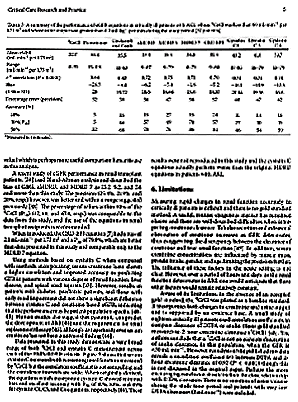

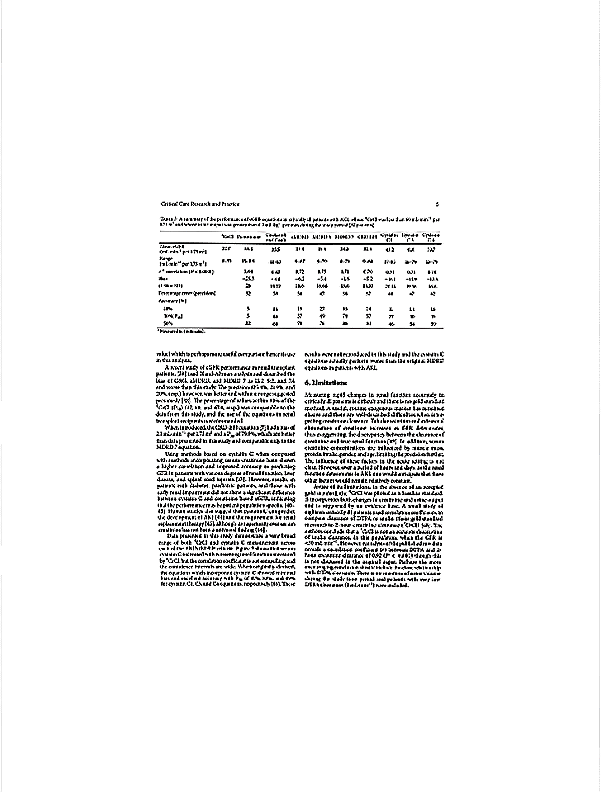

In [ ]:
from IPython.display import Image
display(Image('/kaggle/working/dewarped_rectified_enhanced.png'))
display(Image('/kaggle/working/dewarped_fixed_enhanced.png'))